In [1]:
import duckdb
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config

In [2]:
def fetch_rushes():
	pass

In [3]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 #'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

team_stat_cols = [
 #'completions_team_roll',
 #'attempts_team_roll',
 'carries_team_roll',
 #'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'yards_per_carry_team_roll',
]
opp_stat_cols = [
#'completions_opp_roll',
 #'attempts_opp_roll',
 'carries_opp_roll',
 #'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll',
 'yards_per_carry_opp_roll',
]

game_context_cols = [
	"yardline_100",
	"down",
	"goal_to_go",
	"ydstogo",
	#"posteam_score",
	#"defteam_score",
	#"score_differential",
	#'quarter_seconds_remaining',
	#'half_seconds_remaining',
	#'game_seconds_remaining',
	#"wind",
	#"temp",
	#'spread_line',
	#'total_line',
]

x_cols = game_context_cols +rusher_stat_cols + ['is_first_down', 'is_second_down', 'is_third_down','is_fourth_down', 'first_down', 'touchdown'] #+ ['run_gap_encoded'] + rusher_stat_cols + team_stat_cols + opp_stat_cols 

In [4]:
len(x_cols)

13

In [5]:
rushes = Quack.query(f"""
select pbp.desc,pbp.game_id, pbp.yards_gained,
	case when pbp.run_gap = 'end' then 2
		when pbp.run_gap = 'tackle' then 1
		when pbp.run_gap = 'guard' then 0  else 1 end as run_gap_encoded,
	case when pbp.down = 1 then '1' else 0 end as is_first_down,
	case when pbp.down = 2 then '1' else 0 end as is_second_down,
	case when pbp.down = 3 then '1' else 0 end as is_third_down,
	case when pbp.down = 4 then '1' else 0 end as is_fourth_down,
                     pbp.first_down, pbp.touchdown,
	{', '.join(('pbp.' + x for x in game_context_cols))},
	{', '.join(('t.' + x for x in team_stat_cols))},
	{', '.join(('o.' + x for x in opp_stat_cols))},
	{', '.join(('r.' + x for x in rusher_stat_cols))},
	from pbp join team_feats as t 
	on pbp.posteam = t.team
	and pbp.game_id = t.game_id
	join opp_feats as o
	on pbp.defteam = o.opponent_team
	and pbp.game_id = o.game_id
	join player_weekly_agg as r
	on r.game_id = pbp.game_id
	and pbp.rusher_player_id = r.gsis_id
	and r.team = pbp.posteam
	and pbp.play_type = 'run'
	and pbp.yards_gained is not null
	and pbp.down is not null
    and pbp.penalty = 0
    and pbp.fumble = 0
""")

In [6]:
rushes[rusher_stat_cols] = rushes[rusher_stat_cols].fillna(0)
rushes['yards_shifted'] = rushes['yards_gained'] + 30

In [7]:
def forward(self, x):
	"""
	Args:
		x: (batch, input_dim) - your features, where x[:, 0] is yardline_100
	
	Returns:
		(batch, n_yard_classes) - probability distribution over yards
	"""
	batch_size = x.shape[0]
	
	# Extract yards_to_endzone from first feature (yardline_100)
	yards_to_endzone = x[:, 0].unsqueeze(1)  # (batch, 1)
	
	# Shared features
	features = self.backbone(x)
	
	# Raw logits for yards
	yards_logits = self.yards_head(features)  # (batch, n_yard_classes)
	

	
	
	return masked_logits

In [27]:
import torch
import torch.nn as nn

class ResBlock(nn.Module):
	def __init__(self, n_hidden):
		super().__init__()
		self.layer = nn.Sequential(
			nn.Linear(n_hidden, n_hidden),
			nn.LayerNorm(n_hidden),
			nn.ReLU()
		)
	
	def forward(self, x):
		return x + self.layer(x)

class masked_model(nn.Module):
	def __init__(self, n_in=11, n_out=109, n_hidden=50):
		super(masked_model, self).__init__()
		self.n_out=n_out
		self.main_layers = nn.Sequential(
		nn.Linear(n_in, n_hidden),nn.ReLU(),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		)
		self.output_layer  = nn.Linear(n_hidden, n_out)
		self.td_head = nn.Linear(n_hidden, 1)
	def forward(self, x):

		
		# Extract the feature to pass to the final layer (e.g., the first feature)
		yardline = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]
		yard_values = torch.arange(0, self.n_out, device=x.device).float() 
		yard_values = yard_values.unsqueeze(0)
		mask = (yard_values <= yardline + 30).float()
		td_bin = (yardline + 30).long().squeeze(1)

		x = self.main_layers(x)
		logits = self.output_layer(x)
		td_logits = self.td_head(x)
		batch_indices = torch.arange(logits.size(0), device=logits.device)
		logits[batch_indices, td_bin] = logits[batch_indices, td_bin] + td_logits.squeeze(1) * 3
        

		masked_logits = logits + (mask - 1) * 1e9

		return masked_logits

In [59]:
X = rushes[x_cols]
y = rushes['yards_shifted']
X_td = rushes.loc[rushes.touchdown==1][x_cols].copy().reset_index(drop=True)
y_td = rushes.loc[rushes.touchdown==1]['yards_shifted'].copy().reset_index(drop=True)

In [62]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)

def get_sample(num_samples):
	idx = np.random.randint(0,len(X_tensor), num_samples)
	return X_tensor[idx]

get_sample(2)

model = masked_model(
	n_in=len(x_cols),
	n_out=130,
	n_hidden=64,
)
			# numerical value
c = get_sample(1)
print(c.shape)
pred = model(c)

torch.Size([1, 13])


In [63]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma
    
    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

In [73]:
from torch.utils.data import WeightedRandomSampler, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Create datasets ONCE outside the function
def create_datasets(X, y, test_size=0.1, td_oversample=20.0, random_state=42):
    """Create train/test datasets with TD oversampling weights"""
    
    X_train, X_test, y_train, y_test = train_test_split(
        X.values, y.values, test_size=test_size, random_state=random_state
    )
    
    # Convert to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)
    
    # Create sample weights for TD oversampling
    yardline_train = X_train[:, 0].numpy()
    is_td = (y_train.numpy() == (yardline_train + 30))
    sample_weights = np.ones(len(y_train))
    sample_weights[is_td] = td_oversample
    
    print(f"TD plays: {is_td.sum()} ({100*is_td.mean():.2f}%)")
    print(f"Effective TD representation: {100*is_td.sum()*td_oversample/sample_weights.sum():.2f}%")
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    return train_dataset, test_dataset, sample_weights


def train_model(train_dataset, test_dataset, sample_weights, n_in, n_out, 
                n_hidden=50, epochs=20, batch_size=64, lr=0.001, model=None):
    """Train model using pre-created datasets"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create sampler and loader
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    if not model:
        model = masked_model(n_in=n_in, n_out=n_out, n_hidden=n_hidden).to(device)
    
    criterion = FocalLoss(gamma=2.0)
    criterion_mse = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.1)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_mean_loss = 0
        epoch_class_loss = 0
        num_batches = 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            
            probs = torch.softmax(outputs, dim=1)
            probs_mean = (torch.arange(0, 130, dtype=torch.float32).to(device) * probs).sum(1)
            
            classifier_loss = criterion(outputs, batch_y)
            mean_loss = criterion_mse(probs_mean, batch_y.float())
            loss = classifier_loss + mean_loss
            
            loss.backward()
            optimizer.step()
            
            epoch_mean_loss += mean_loss.item()
            epoch_class_loss += classifier_loss.item()
            num_batches += 1
        
        print(f"Epoch {epoch+1}/{epochs}, Classifier: {epoch_class_loss/num_batches:.4f}, MSE: {epoch_mean_loss/num_batches:.4f}")
    
    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            preds = model(batch_x)
            all_preds.append(preds)
            all_labels.append(batch_y)
    
    test_preds = torch.cat(all_preds)
    test_y = torch.cat(all_labels)
    
    test_loss = criterion(test_preds, test_y).item()
    accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    
    return model


# Usage:
train_dataset, test_dataset, sample_weights = create_datasets(X, y, td_oversample=10.0)

# Train model
model = train_model(train_dataset, test_dataset, sample_weights, 
                    n_in=len(x_cols), n_out=130, n_hidden=512, epochs=5, batch_size=64)

# Want to try different hyperparameters? Just reuse the same datasets!
#model2 = train_model(train_dataset, test_dataset, sample_weights,
#                     #n_in=11, n_out=109, n_hidden=100, epochs=30, lr=0.0005)

TD plays: 4722 (3.43%)
Effective TD representation: 26.23%
Epoch 1/5, Classifier: 12.5968, MSE: 70.6187
Epoch 2/5, Classifier: 2.9131, MSE: 36.0540
Epoch 3/5, Classifier: 1.8946, MSE: 13.6730
Epoch 4/5, Classifier: 1.9421, MSE: 16.3525
Epoch 5/5, Classifier: 1.8339, MSE: 12.9601
Test Loss: 2.3448, Test Accuracy: 0.1504


In [ ]:
def train_model(X_data, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=512, model=None):

	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	y = torch.tensor(y,dtype=torch.long).to(device)
	# Define the model, loss function, and optimizer

	X_tensor = torch.tensor(X_data.values, dtype=torch.float32).to(device)
	if not model:
		model = masked_model(
		n_in=n_in,
		n_out=n_out,
		n_hidden=n_hidden,
		).to(device)
	criterion = FocalLoss(gamma=2.0) # Suitable for classification
	criterion_mse = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)

	num_samples = X_tensor.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 5  # 20% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices

	Xtr = X_tensor[train_indices].to(device)
	Xtst = X_tensor[test_indices].to(device)
	train_y = y[train_indices].to(device)
	test_y =  y[test_indices].to(device)

	# Training loop
	epochs = epochs
	batch_size = 64

	for epoch in range(epochs):
		model.train()
		permutation = torch.randperm(Xtr.size(0))
		epoch_mean_loss = 0
		epoch_class_loss = 0

		for i in range(0, Xtr.size(0), batch_size):
			indices = permutation[i:i + batch_size]
			batch_x, batch_y = Xtr[indices], train_y[indices]

			optimizer.zero_grad()
			outputs = model(batch_x)  # Shape: [batch_size, n_out]
			probs = torch.softmax(outputs, dim=1)
			probs_mean = (torch.arange(0,130, dtype=torch.float32).to(device) * probs).sum(1)
			classifier_loss = criterion(outputs, batch_y)
			mean_loss =  criterion_mse(probs_mean, batch_y.float())
			loss = classifier_loss + mean_loss  # batch_y must be [batch_size] with class indices
			loss.backward()
			optimizer.step()

			epoch_mean_loss += mean_loss.item()
			epoch_class_loss += classifier_loss.item()

		print(f"Epoch {epoch+1}/{epochs}, Classifier Loss: {epoch_class_loss/len(Xtr):.4f}, MSE Loss: {epoch_mean_loss/len(Xtr):.4f}")

		# Evaluation on the test set
	model.eval()
	with torch.no_grad():
		test_preds = model(Xtst)  # Shape: [num_samples, 100]
		test_loss = criterion(test_preds, test_y).item() 
		accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
	print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

	test_preds = F.softmax(test_preds,dim=1)[0].to('cpu')
	samples = torch.clamp( torch.multinomial(test_preds,100,replacement=True),max=76) - 30
	avg = round(samples.double().mean().item(), 3)
	print(avg)
	plt.hist(test_preds, alpha=0.5, color='r')
	plt.hist(test_y.to('cpu'), alpha=0.5, color='b')
	return model

Epoch 1/1, Classifier Loss: 0.2244, MSE Loss: 0.5861
Test Loss: 7.2822, Test Accuracy: 0.1488
0.68
Epoch 1/1, Classifier Loss: 0.0092, MSE Loss: 0.5145
Test Loss: 0.0000, Test Accuracy: 1.0000
7.0
Epoch 1/1, Classifier Loss: 0.0973, MSE Loss: 0.5425
Test Loss: 5.8903, Test Accuracy: 0.1564
2.68
Epoch 1/1, Classifier Loss: 0.0135, MSE Loss: 0.7113
Test Loss: 0.0000, Test Accuracy: 1.0000
8.0
Epoch 1/1, Classifier Loss: 0.0810, MSE Loss: 0.5721
Test Loss: 3.5948, Test Accuracy: 0.1484
3.58
Epoch 1/1, Classifier Loss: 0.0070, MSE Loss: 0.4490
Test Loss: 0.0000, Test Accuracy: 1.0000
4.0
Epoch 1/1, Classifier Loss: 0.0669, MSE Loss: 0.5013
Test Loss: 3.4653, Test Accuracy: 0.1537
3.37
Epoch 1/1, Classifier Loss: 0.0056, MSE Loss: 0.4484
Test Loss: 0.0000, Test Accuracy: 1.0000
46.0
Epoch 1/1, Classifier Loss: 0.0572, MSE Loss: 0.5024
Test Loss: 3.2997, Test Accuracy: 0.1541
4.19
Epoch 1/1, Classifier Loss: 0.0037, MSE Loss: 0.3626
Test Loss: 0.0000, Test Accuracy: 1.0000
16.0
Epoch 1/1, Cl

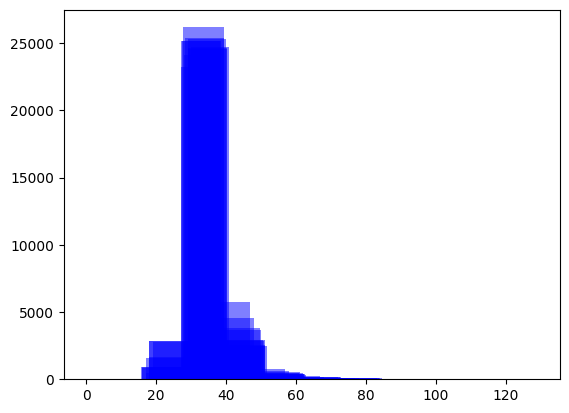

In [65]:
rush_yards_model = train_model(X,y, len(x_cols), 130, n_hidden = 512, epochs=1)
for i in range(9):
	rush_yards_model = train_model(X_td,y_td, len(x_cols), 130, n_hidden = 512, epochs=1, model=rush_yards_model)
	rush_yards_model = train_model(X,y, len(x_cols), 130, n_hidden = 512, epochs=1, model=rush_yards_model)
	
#Epoch 10/10, Classifier Loss: 0.0408, MSE Loss: 0.3164
#Epoch 10/10, Classifier Loss: 0.0405, MSE Loss: 0.2760 with touchdown head thing

In [74]:

rush_yards_model = model.to('cpu')
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
	'rush_yard_cols':x_cols
}
feature_config

update_config(feature_config)

Actual mean: 1.83, Model mean: 0.51
number of datapoints: 1154


(-10.0, 40.0)

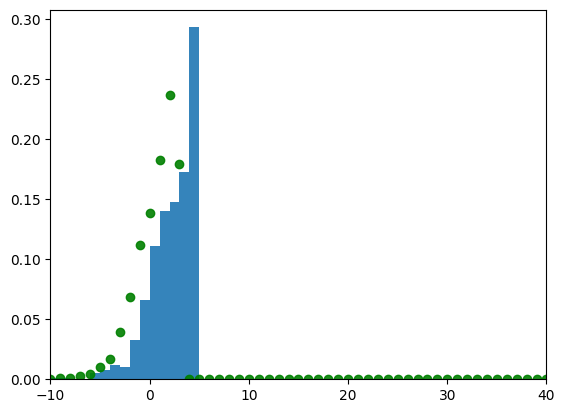

In [76]:
def sample_model_yardline(yard, down):
	inp = rushes.loc[(rushes.yardline_100==yard), x_cols]
	y = rushes.loc[ (rushes.yardline_100==yard), 'yards_gained']

	inp =  torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).mean(0).detach().numpy()
	exp_logits = np.exp(out - np.max(out))
	probs = exp_logits / exp_logits.sum()
	plt.hist(y, range(-30,100), density=True, alpha=0.9)

	actual_mean = y.mean()
	model_mean = (np.arange(len(probs)) - 30) @ probs  # adjust if 0th class = -30
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	print(f'number of datapoints: {len(inp)}')
	return probs

yard = 4
down = 1
plt.scatter(range(-30 ,100 ),sample_model_yardline(yard, down), color='green', alpha = 0.9)
plt.xlim(-10,40)

torch.Size([1, 21])
torch.Size([1, 21])
torch.Size([1, 21])
torch.Size([1, 21])


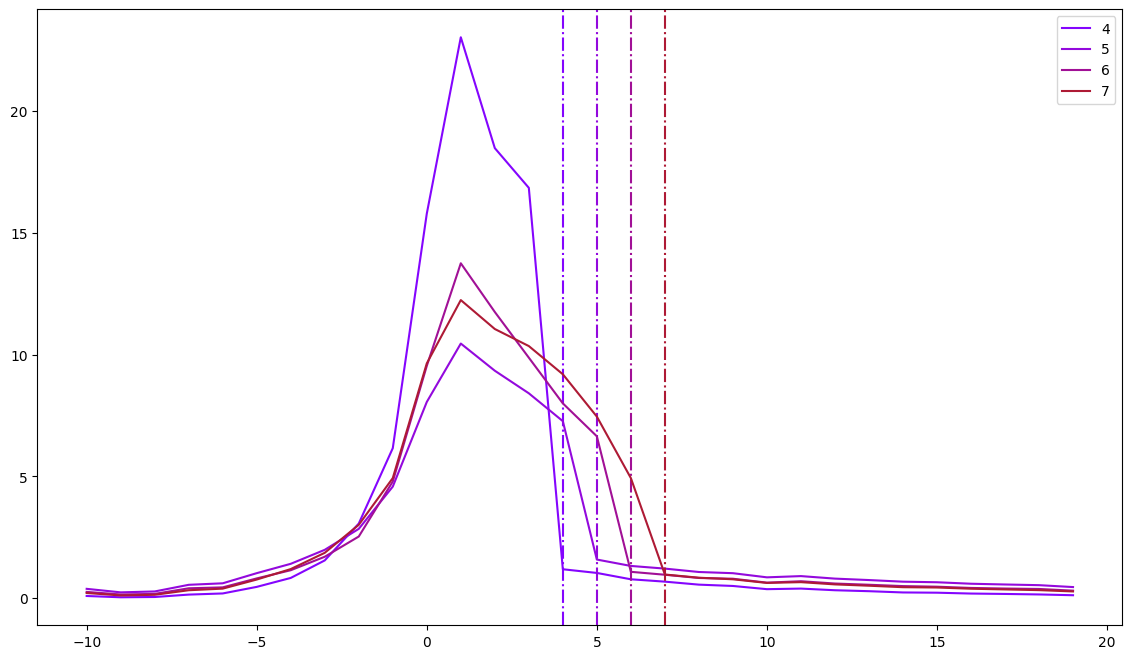

In [ ]:
import matplotlib.cm as cm
colormap = cm.gnuplot
plt.figure(figsize=(14, 8))
num_yardlines = 15
for yardline in range(4,8):

    color = colormap(yardline / num_yardlines) 
    down=1
    test = rushes.loc[rushes.yardline_100==yardline]
    xx = torch.Tensor(test[x_cols].sample(1).values)
    print(xx.shape)
    with torch.no_grad():
        xy = rush_yards_model(xx)
        xy[:,30+yardline:] /= 2
        xy = (100 * F.softmax(xy,dim=1))[0]
        x_range = range(-10,20)
    plt.axvline(yardline, color=color, linestyle='-.')
    plt.plot(x_range, xy[20:50], label=yardline, color=color)
    plt.legend()